In [1]:
import findspark
findspark.init('/home/linux/spark-3.1.2-bin-hadoop3.2')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import functions as F

# About the Dataset

This dataset has been taken from Kaggle : [Credit Card Lead Prediction](https://www.kaggle.com/swastikmohanty845/jobathon-may-2021-credit-card-lead-prediction) . This dataset was part of May 2021 Job-a-thon conducted my Analytics Vidhya.

**Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.**

**The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like telecasting, e-mails, recommendations on net banking, mobile banking, etc.**

**In this case, the Happy Customer Bank wants to cross-sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.**

 * ID - Customer Unique Ids 
 * Gender - Customer Gender
 * Age - Customer Age (in Years)
 * Region_Code - Customer Region
 * Occupation - Customer occupation
 * Channel_Code - Customer Channel Code (Encoded)
 * Vintage - Customer Vintage(In Months)
 * Credit_Product - Customer Has Any Active Credit Product
 * Avg_Account_Balance - Customer In last 12 Months Balance
 * Is_Active - Customer Is Active(In 3 Months) 

## Contents :

#### * [Import the dataset](#dataset)
#### * [Missing values](#missing_values)
#### * [Exploratory Data Anlaysis](#eda)
   * [GroupByGender](#gender)
   * [Age v/s Vintage](#agevsvintage)
   * [Vintage v/s Avg_Account_Balance](#agevsavgaccount)

####  * [DataFrame : Exploring various methods available in Spark SQL ](#sparksql)
* [Grouped Data](#grouped_data)

In [3]:
#Importing Pyspark SQL module and create a Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Session').getOrCreate()

#spark session details
spark.sparkContext

<SparkContext master=local[*] appName=Session>

# Import the dataset 
<a id = 'dataset'></a>

In [4]:
#Create a schema for the columns before importing the dataset
from pyspark.sql.types import StructType,StructField,IntegerType,StringType

data_types = [StructField('ID',StringType(),True),StructField('Gender',StringType(),True),
               StructField("Age",IntegerType(),True),StructField('Region_Code',StringType(),True),
               StructField('Occupation',StringType(),True),StructField('Channel_Code',StringType(),True),
               StructField('Vintage',IntegerType(),True),StructField('Credit_Product',StringType(),True),
               StructField('Avg_Account_Balance',IntegerType(),True),StructField('Is_Active',StringType(),True),
               StructField('Is_Lead',IntegerType(),True)]

#create a struct type
field = StructType(fields=data_types)

In [5]:
#spark.read returns a Dataframe reader
#spark.read.csv is used to read the input csv file

df = spark.read.csv('Train_Data.csv',inferSchema=True,header=True,schema=field)

#header --> to read first line as header
#inferSchma --> infers the input schema automatically from data.

In [6]:
#printSchema 
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Region_Code: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Channel_Code: string (nullable = true)
 |-- Vintage: integer (nullable = true)
 |-- Credit_Product: string (nullable = true)
 |-- Avg_Account_Balance: integer (nullable = true)
 |-- Is_Active: string (nullable = true)
 |-- Is_Lead: integer (nullable = true)



In [36]:
#Shape of the dataset
df.count(),len(df.columns)

(245725, 11)

In [7]:
#To show the first 5 rows in Pandas format
df.limit(5).toPandas()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


# Find missing values in Dataset
<a id = 'missing_values'></a>

In [8]:
col = df.columns

for i in col :
    missing_val = df.filter(df[i].isNull()).count()
    print('The no. of missing values for "{:s}" is {:d}'.format(i,missing_val))

The no. of missing values for "ID" is 0
The no. of missing values for "Gender" is 0
The no. of missing values for "Age" is 0
The no. of missing values for "Region_Code" is 0
The no. of missing values for "Occupation" is 0
The no. of missing values for "Channel_Code" is 0
The no. of missing values for "Vintage" is 0
The no. of missing values for "Credit_Product" is 29325
The no. of missing values for "Avg_Account_Balance" is 0
The no. of missing values for "Is_Active" is 0
The no. of missing values for "Is_Lead" is 0


### Since `Credit Product` has missing values and it is categorical. We will be imputing with the most frequent category.

In [9]:
#Find the most frequency category 
count_df = df.groupBy('Credit_Product').count().toPandas()
count_df.set_index('Credit_Product').sort_values('count',ascending=False)

#Since 'No' is higher, we will be filling Nan values with No.

,count
Credit_Product,
No,144357
Yes,72043
NaN,29325


In [10]:
df = df.na.fill('No','Credit_Product')

In [11]:
count_df = df.groupBy('Credit_Product').count().toPandas()
count_df.set_index('Credit_Product').sort_values('count',ascending=False)

#Missing values has been filled.

,count
Credit_Product,
No,173682
Yes,72043


# EDA - Credit Card Lead
<a id = 'eda'></a>
### GroupBy `Gender`
<a id = 'gender'></a>

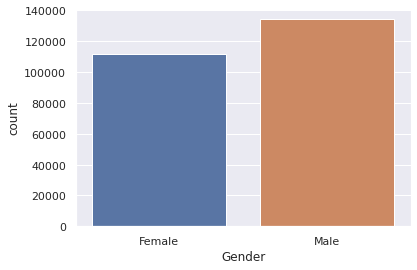

In [12]:
#No. of males and females

sns.set_theme(style="darkgrid")
df_gender = df.select('Gender','Age').toPandas()
_ = sns.countplot(data=df_gender,x='Gender')

CPU times: user 8.93 s, sys: 140 ms, total: 9.07 s
Wall time: 9.95 s


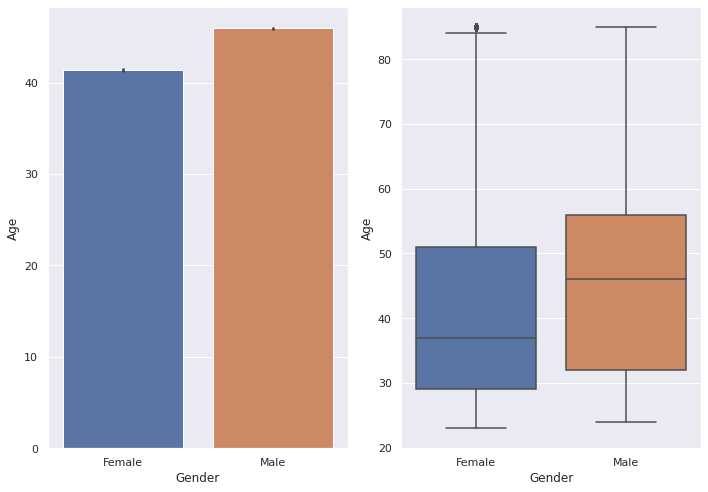

In [13]:
%%time

#Avg age of males and females.
df_gender = df.select('Gender','Age').toPandas()

fig,ax = plt.subplots(1,2,figsize=(10,7))
_ = sns.barplot(data=df_gender,x='Gender',y='Age',ax=ax[0])
_ = sns.boxplot(data=df_gender,x='Gender',y='Age',ax=ax[1])
plt.tight_layout()

CPU times: user 2.43 s, sys: 290 ms, total: 2.72 s
Wall time: 3.73 s


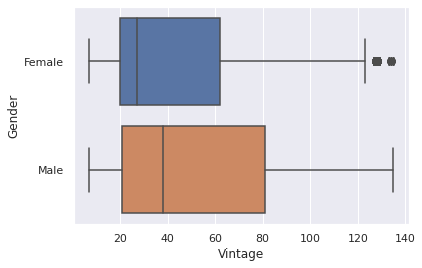

In [14]:
%%time

#Distribution of gender with Vintage
df_gender = df.select('Gender','Vintage').toPandas()
_ = sns.boxplot(data=df_gender,x='Vintage',y='Gender')

CPU times: user 2.02 s, sys: 345 ms, total: 2.37 s
Wall time: 3.28 s


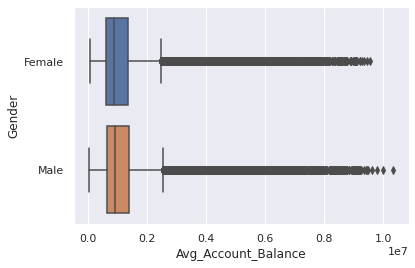

In [15]:
%%time

#Distribution of gender with Avg_Account_Balance
df_gender = df.select('Gender','Avg_Account_Balance').toPandas()
_ = sns.boxplot(data=df_gender,x='Avg_Account_Balance',y='Gender')

In [16]:
#Active members across the gender
df.crosstab('Gender','Is_Active').toPandas()

,Gender_Is_Active,No,Yes
0,Male,78249,55948
1,Female,72041,39487


In [17]:
#Lead members across the gender
df.crosstab('Gender','Is_Lead').toPandas()

,Gender_Is_Lead,0,1
0,Male,98614,35583
1,Female,88823,22705


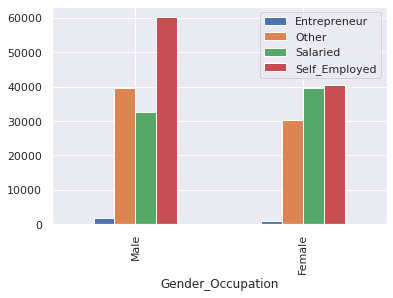

In [18]:
#Occupation across the gender
_ = df.crosstab('Gender','Occupation').toPandas()
_.set_index('Gender_Occupation').plot(kind='bar');

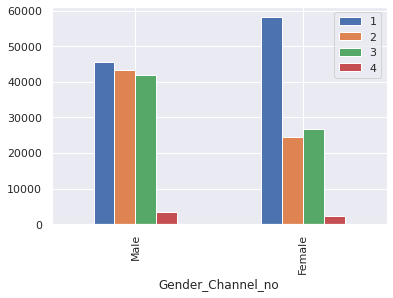

In [19]:
#Channel code among genders 
_ = df.select('Gender',(df['Channel_Code'].substr(2,1)).alias('Channel_no'))
_ = _.crosstab('Gender','Channel_no').toPandas()
_.set_index('Gender_Channel_no').plot(kind='bar');

In [20]:
#Channel code among genders 
_ = df.select('Gender',(df['Region_Code'].substr(3,3)).alias('Region_no'))
_.crosstab('Gender','Region_no').toPandas()

,Gender_Region_no,250,251,252,253,254,255,256,257,258,...,275,276,277,278,279,280,281,282,283,284
0,Male,1270,3436,2133,1136,15384,1036,1376,3104,1058,...,1585,1548,6926,1084,2082,7172,2707,3244,16364,10846
1,Female,1226,2514,2153,722,11456,982,1471,2997,893,...,1660,1216,5900,738,1894,5603,2386,2585,13052,8474


## `Age` v/s `Vintage`
<a id = 'agevsvintage'></a>

<AxesSubplot:xlabel='Age', ylabel='Vintage'>

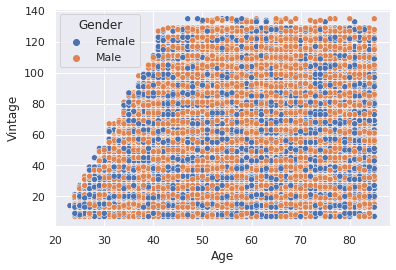

In [79]:
data = df.select('Age','Vintage','Gender').toPandas()
_ = sns.scatterplot(data=data,x='Age',y= 'Vintage',hue='Gender')

## `Vintage` v/s `Avg_Account_Balance`
<a id = 'agevsavgaccount'></a>

/home/linux/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


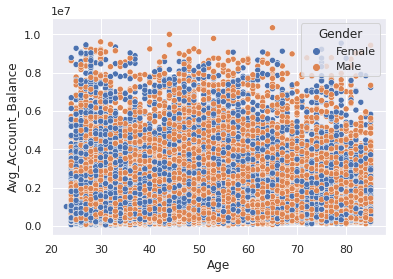

In [21]:
data = df.select('Age','Avg_Account_Balance','Gender').toPandas()
_ = sns.scatterplot(data=data,x='Age',y= 'Avg_Account_Balance',hue='Gender')

### `Avg Account balance` by `Region code`

In [29]:
data = df.groupBy('Region_Code').mean()
data.select('Region_Code',(data['avg(Avg_Account_Balance)']).alias('Avg_Account_Balance_by_Region')).sort('Region_code').show()

+-----------+-----------------------------+
|Region_Code|Avg_Account_Balance_by_Region|
+-----------+-----------------------------+
|      RG250|            735763.9759615385|
|      RG251|            741677.9529411765|
|      RG252|             634770.713019132|
|      RG253|           1374248.0543595264|
|      RG254|            1407392.135394933|
|      RG255|             868249.742814668|
|      RG256|            674806.8321039691|
|      RG257|            858105.4543517457|
|      RG258|            705005.0302409021|
|      RG259|            625180.4145398298|
|      RG260|             758465.152733119|
|      RG261|            981286.4003668282|
|      RG262|           1200158.0458612975|
|      RG263|            831138.9753186873|
|      RG264|            674554.0107411386|
|      RG265|            805709.6461836998|
|      RG266|            696652.2281368822|
|      RG267|            682724.5257181029|
|      RG268|           1463900.0817610063|
|      RG269|           1027003.

### `Occupation` v/s `Is_Active`

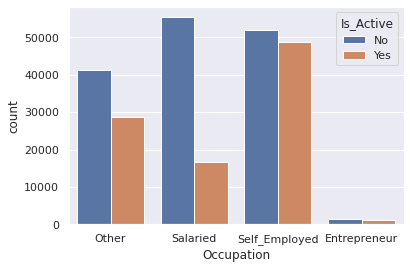

In [32]:
df_occupation = df.select('Occupation','Is_Active').toPandas()
_ = sns.countplot(data=df_occupation,x='Occupation',hue='Is_Active')

# DataFrame : Exploring various methods available in Spark SQL
<a id = 'sparksql'></a>

A distributed collection of data grouped into named columns.A DataFrame is equivalent to a relational table in Spark SQL.

In [6]:
'''agg :: Aggregate on the entire DataFrame without groups '''
#collect - is an action operation to get data in Row format

#Method 1
df.agg({'Avg_Account_Balance':'max'}).collect()

#Method 2
df.agg(F.sum(df['Avg_Account_Balance'])).collect()

[Row(sum(Avg_Account_Balance)=277276851998)]

In [8]:
#Get column names
df.columns

['ID',
 'Gender',
 'Age',
 'Region_Code',
 'Occupation',
 'Channel_Code',
 'Vintage',
 'Credit_Product',
 'Avg_Account_Balance',
 'Is_Active',
 'Is_Lead']

In [9]:
#Correlation between two variables/columns
df.corr('Age','Avg_Account_Balance')

0.14523218931496795

In [10]:
#Number of rows in dataframe
df.count()

245725

In [11]:
#Calculates the covariance
df.cov('Age','Avg_Account_Balance')

1836884.1380121398

In [7]:
#Cross tab : creates a frequency table
df.crosstab('Gender','Is_Active').show()

+----------------+-----+-----+
|Gender_Is_Active|   No|  Yes|
+----------------+-----+-----+
|            Male|78249|55948|
|          Female|72041|39487|
+----------------+-----+-----+



In [8]:
#Describe : Computes basic statistics for numeric and string columns.
df.describe().toPandas()

,summary,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,count,245725,245725,245725,245725,245725,245725,245725,216400,245725,245725,245725
1,mean,None,None,43.85630684708516,None,None,None,46.95914131651236,None,1128403.1010194323,None,0.23720826126767727
2,stddev,None,None,14.828671804648037,None,None,None,32.35313570875429,None,852936.3560692759,None,0.42537188248718977
3,min,222A8XWS,Female,23,RG250,Entrepreneur,X1,7,No,20790,No,0
4,max,ZZZZ6MXS,Male,85,RG284,Self_Employed,X4,135,Yes,10352009,Yes,1


In [27]:
#Returns a new dataframe with distinct rows
df_distinct = df.distinct()

## Functions

In [16]:
#abs : Computes the abs value
df.select((-1*df['Age']).alias('Inverse_Age'),F.abs('Age')).show(3)   #returns column with absolute values

+-----------+--------+
|Inverse_Age|abs(Age)|
+-----------+--------+
|        -73|      73|
|        -30|      30|
|        -56|      56|
+-----------+--------+
only showing top 3 rows



In [19]:
#approx_count_distinct : returns count of distinct rows
df.select(F.approx_count_distinct('Age').alias('Distinct Age counts')).show()

+-------------------+
|Distinct Age counts|
+-------------------+
|                 64|
+-------------------+



In [37]:
#array : create a new array
arr = df.select(F.array('Age','Vintage').alias('col1'))
arr.show(3)

+--------+
|    col1|
+--------+
|[73, 43]|
|[30, 32]|
|[56, 26]|
+--------+
only showing top 3 rows



In [40]:
#array_contains : checks if a value is in array or not - returns True or False
arr.select(F.array_contains(arr.col1,30)).show(3)

+------------------------+
|array_contains(col1, 30)|
+------------------------+
|                   false|
|                    true|
|                   false|
+------------------------+
only showing top 3 rows



In [41]:
#array_distinct : removes duplicate value from the array
arr.select(F.array_distinct(arr.col1)).show(3)

+--------------------+
|array_distinct(col1)|
+--------------------+
|            [73, 43]|
|            [30, 32]|
|            [56, 26]|
+--------------------+
only showing top 3 rows



In [43]:
#array_max : returns max value in array
arr.select(F.array_max(arr.col1)).show(3)

+---------------+
|array_max(col1)|
+---------------+
|             73|
|             32|
|             56|
+---------------+
only showing top 3 rows



In [44]:
#array_max : returns min value in array
arr.select(F.array_min(arr.col1)).show(3)

+---------------+
|array_min(col1)|
+---------------+
|             43|
|             30|
|             26|
+---------------+
only showing top 3 rows



## Grouped Data
<a id = 'grouped_data'></a>

In [9]:
#Get the average for each gender group
df.groupBy('Gender').avg().show()

+------+----------------+-----------------+------------------------+-------------------+
|Gender|        avg(Age)|     avg(Vintage)|avg(Avg_Account_Balance)|       avg(Is_Lead)|
+------+----------------+-----------------+------------------------+-------------------+
|Female|41.3826393372068|41.76425650957607|       1107373.188822538|0.20358116347464314|
|  Male|45.9121142797529|51.27648904222896|      1145880.5710634366|0.26515495875466666|
+------+----------------+-----------------+------------------------+-------------------+



In [32]:
#Counts the number of records for each group.
df.groupBy('Gender').count().show()

+------+------+
|Gender| count|
+------+------+
|Female|111528|
|  Male|134197|
+------+------+



In [34]:
#Computes the max value for each numeric columns for each group.
# Mean and Avg : both are same
df.groupBy('Gender').max().show()

+------+--------+------------+------------------------+------------+
|Gender|max(Age)|max(Vintage)|max(Avg_Account_Balance)|max(Is_Lead)|
+------+--------+------------+------------------------+------------+
|Female|      85|         135|                 9546317|           1|
|  Male|      85|         135|                10352009|           1|
+------+--------+------------+------------------------+------------+



In [35]:
#Computes the min value for each numeric columns for each group.
df.groupBy('Gender').min().show()

+------+--------+------------+------------------------+------------+
|Gender|min(Age)|min(Vintage)|min(Avg_Account_Balance)|min(Is_Lead)|
+------+--------+------------+------------------------+------------+
|Female|      23|           7|                   45657|           0|
|  Male|      24|           7|                   20790|           0|
+------+--------+------------+------------------------+------------+



In [37]:
#Pivots a column of the current DataFrame and perform the specified aggregation.
df.groupBy('Gender').pivot('Is_Lead').count().show()

+------+-----+-----+
|Gender|    0|    1|
+------+-----+-----+
|Female|88823|22705|
|  Male|98614|35583|
+------+-----+-----+

